In [0]:
%run ./includes/utilities

In [0]:
# Removing all the warnings
import warnings
warnings.filterwarnings('ignore')

In [0]:
dbutils.fs.rm(projectPath, recurse=True)

Out[7]: True

In [0]:
process_file("health_profile_data.snappy.parquet", silverDailyPath, "health_profile_data")
process_file("user_profile_data.snappy.parquet", dimUserPath, "user_profile_data")

Retrieve health_profile_data.snappy.parquet.
Load health_profile_data.snappy.parquet to /dbacademy/nvkanirudh/mlmodels/profile/daily/
Register health_profile_data using path: /dbacademy/nvkanirudh/mlmodels/profile/daily/
Retrieve user_profile_data.snappy.parquet.
Load user_profile_data.snappy.parquet to /dbacademy/nvkanirudh/mlmodels/profile/users/
Register user_profile_data using path: /dbacademy/nvkanirudh/mlmodels/profile/users/


In [0]:
%run ./includes/configuration

In [0]:
user_profile_df = spark.read.table("user_profile_data")
health_profile_df = spark.read.table("health_profile_data")

Pandas dataframe loads the data into the memory whereas the spark dataframe is a reference to where the data is in the disk (lazt loading)

In [0]:
print("User Profile Data")
user_profile_df.printSchema()
print("Health Profile Data")
health_profile_df.printSchema()

User Profile Data
root
 |-- _id: string (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- lifestyle: string (nullable = true)
 |-- female: boolean (nullable = true)
 |-- country: string (nullable = true)
 |-- occupation: string (nullable = true)

Health Profile Data
root
 |-- dte: timestamp (nullable = true)
 |-- _id: string (nullable = true)
 |-- resting_heartrate: double (nullable = true)
 |-- active_heartrate: double (nullable = true)
 |-- BMI: double (nullable = true)
 |-- VO2_max: double (nullable = true)
 |-- workout_minutes: double (nullable = true)



In [0]:
user_profile_df.count()

Out[14]: 3000

In [0]:
from pyspark.sql.functions import min, max

display(health_profile_df.select(min("dte"), max("dte")))

min(dte),max(dte)
2019-01-01T00:00:00.000+0000,2019-12-31T00:00:00.000+0000


In [0]:
display(user_profile_df.select("lifestyle").distinct())

lifestyle
sedentary
weight trainer
cardio trainer


In [0]:
user_profile_sample_df = user_profile_df.sample(0.03)

display(user_profile_sample_df.groupby("lifestyle").count())

lifestyle,count
sedentary,23
weight trainer,36
cardio trainer,34


In [0]:
health_profile_sample_df = (user_profile_sample_df.join(health_profile_df, "_id"))

assert 365*user_profile_sample_df.count() == health_profile_sample_df.count()

In [0]:
from pyspark.sql.functions import mean, col

health_tracker_sample_agg_df = (
    health_profile_sample_df.groupby("_id", "lifestyle").agg(
        mean(col("BMI")).alias("mean_BMI"),
        mean(col("active_heartrate")).alias("mean_active_heartrate"),
        mean(col("resting_heartrate")).alias("mean_resting_heartrate"),
        mean(col("VO2_max")).alias("mean_VO2_max")
    )
)

The below step is not really important because, I am loading the data into delta table so that the data can be read in other notebooks. Since I am working in a single notebook, this is not really required.

In [0]:
(
  health_tracker_sample_agg_df.write
  .format("delta")
  .mode("overwrite")
  .save(goldPath + "health_tracker_sample_agg")
)

In [0]:
health_tracker_sample_agg_pandas_df = health_tracker_sample_agg_df.toPandas()

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [0]:
lifestyles = health_tracker_sample_agg_pandas_df["lifestyle"].unique()
lifestyles

Out[23]: array(['weight trainer', 'sedentary', 'cardio trainer'], dtype=object)

In [0]:
health_tracker_sample_agg_pandas_df.dtypes

Out[24]: _id                        object
lifestyle                  object
mean_BMI                  float64
mean_active_heartrate     float64
mean_resting_heartrate    float64
mean_VO2_max              float64
dtype: object

In [0]:
features = health_tracker_sample_agg_pandas_df.select_dtypes(exclude=["object"])
target = health_tracker_sample_agg_pandas_df[["lifestyle"]].copy()

Out[26]: <seaborn.axisgrid.PairGrid at 0x7f1890334460>

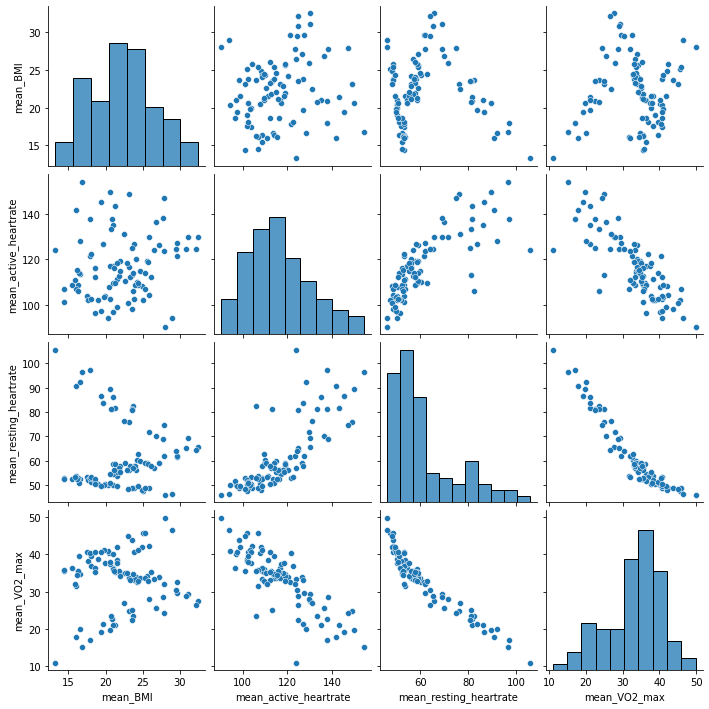

In [0]:
sns.pairplot(features)

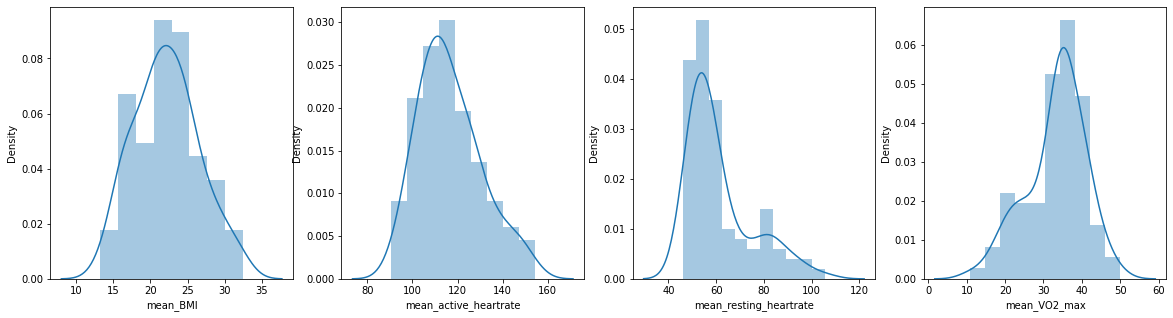

In [0]:
fig, ax = plt.subplots(1,4, figsize=(20,5))

for i, feature in enumerate(features):
    sns.distplot(features[feature], ax=ax[i])

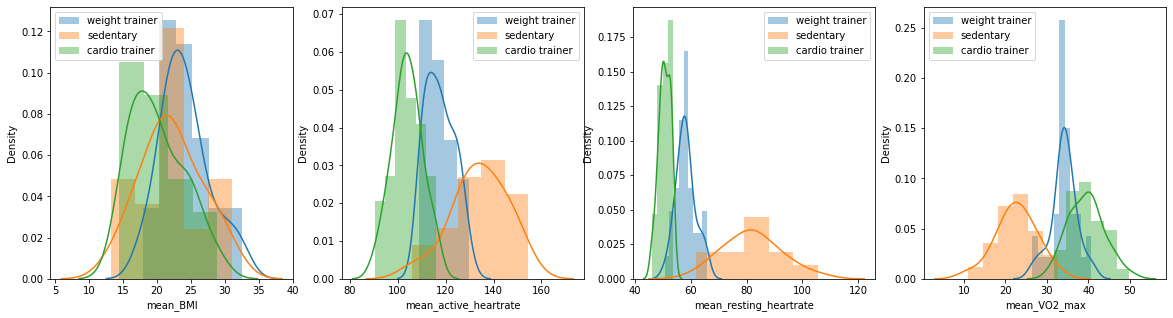

In [0]:
fig, ax = plt.subplots(1,4, figsize=(20,5))

for i, feature in enumerate(features):
    for lifestyle in lifestyles:
        subset = features[target["lifestyle"] == lifestyle]
        sns.distplot(subset[feature], ax=ax[i], label=lifestyle)
    ax[i].legend()

Out[29]: <AxesSubplot:>

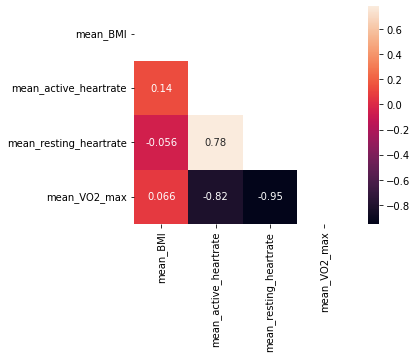

In [0]:
corr = features.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 0)] = True
sns.heatmap(corr, mask=mask, square=True, annot=True)

In [0]:
from sklearn.manifold import TSNE

np.random.seed(10)
tsne = TSNE(n_components=2)

features_in_2d = tsne.fit_transform(features)
features_in_2d = pd.DataFrame(features_in_2d)

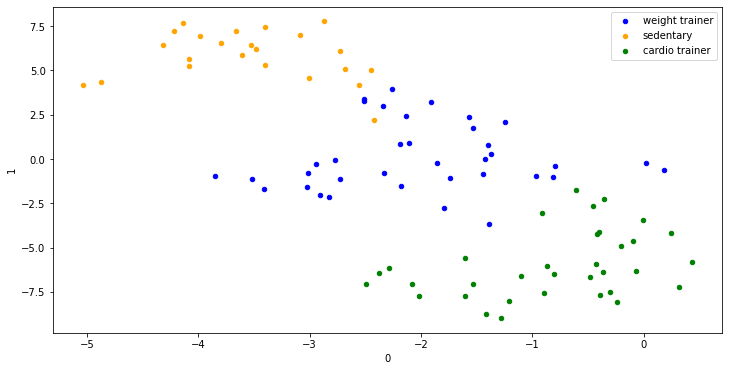

In [0]:
colors = ("blue", "orange", "green")
fig, ax = plt.subplots(1,1,figsize=(12,6))

for color, lifestyle in zip(colors, lifestyles):
    two_dim_per_lifestyle = features_in_2d[target.lifestyle == lifestyle]
    two_dim_per_lifestyle.plot(x=0, y=1, kind="scatter", c=color, label=lifestyle, ax=ax)

In [0]:
%run ./includes/preprocessing

In [0]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
target["lifestyle_encoded"] = le.fit_transform(target["lifestyle"])

In [0]:
from sklearn.model_selection import train_test_split

(trainX, testX, trainY, testY) = train_test_split(features_in_2d, target.lifestyle_encoded)

In [0]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty="none")

lr.fit(trainX, trainY)
lr.score(testX, testY)

Out[42]: 0.9583333333333334

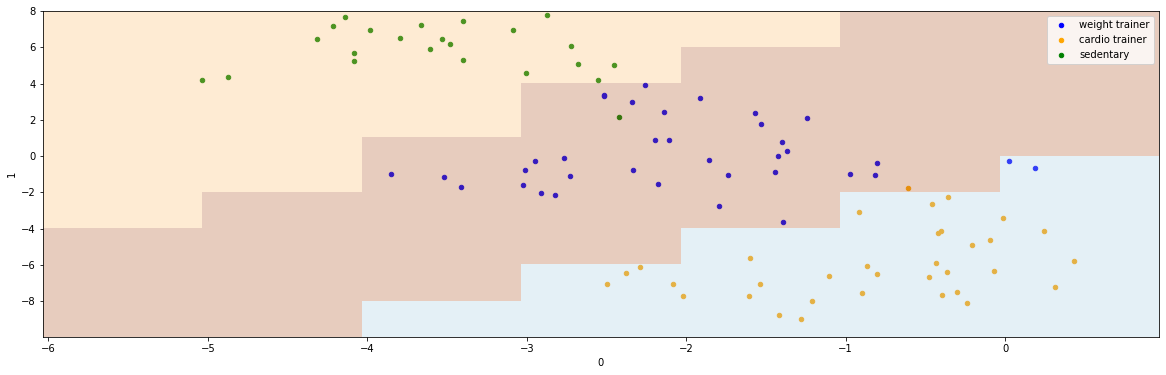

In [0]:
fig, ax = plt.subplots(figsize=(20, 6))

scatter_plot_with_decision_boundary(ax, features_in_2d, target, lr)

In [0]:
(features_train, features_test, target_train, target_test) = train_test_split(features, target.lifestyle_encoded)

In [0]:
lr.fit(features_train, target_train)
lr.score(features_test, target_test)

Out[45]: 0.875

In [0]:
lr = LogisticRegression(penalty="none", max_iter=1e4)
lr.fit(features_train, target_train)
lr.score(features_test, target_test)

Out[46]: 0.9166666666666666

In [0]:
def generate_bootstrap_sample():
    df = health_tracker_sample_agg_pandas_df
    sample_df_list = []
    for lifestyle in lifestyles:
        sample_df_list.append(df[df.lifestyle == lifestyle].sample(5))
    return pd.concat(sample_df_list)

In [0]:
generate_bootstrap_sample()

,_id,lifestyle,mean_BMI,mean_active_heartrate,mean_resting_heartrate,mean_VO2_max
75,d7e870c8-e48a-11ea-8204-0242ac110002,weight trainer,25.734592,118.729839,58.611992,32.973883
38,d7328f24-e48a-11ea-8204-0242ac110002,weight trainer,26.463926,124.075785,56.805052,33.480313
79,e159745e-e48a-11ea-8204-0242ac110002,weight trainer,30.869113,124.611551,65.113368,28.863015
65,da8c8846-e48a-11ea-8204-0242ac110002,weight trainer,18.064733,122.538338,53.108013,36.864653
91,df32abdc-e48a-11ea-8204-0242ac110002,weight trainer,29.577031,127.300256,61.764445,29.607297
90,fb7b38d6-e48a-11ea-8204-0242ac110002,sedentary,22.447734,130.991588,76.417718,26.926159
55,fb040270-e48a-11ea-8204-0242ac110002,sedentary,20.729625,133.229071,81.147416,23.446257
48,ffbbb9ca-e48a-11ea-8204-0242ac110002,sedentary,16.564088,128.281638,92.050904,20.014434
68,f8c8ecfa-e48a-11ea-8204-0242ac110002,sedentary,20.595253,149.663945,89.320090,19.804370
1,f26af5ec-e48a-11ea-8204-0242ac110002,sedentary,16.012466,141.890098,90.752144,17.722379


In [0]:
subsample_sets = [generate_bootstrap_sample() for _ in range(10)]

In [0]:
[len(s) for s in subsample_sets]

Out[50]: [15, 15, 15, 15, 15, 15, 15, 15, 15, 15]

In [0]:
le.fit_transform(health_tracker_sample_agg_pandas_df["lifestyle"])\

for sample_set in subsample_sets:
    sample_set["lifestyle_encoded"] = le.transform(sample_set["lifestyle"])

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [0]:
feature_subset = ["mean_active_heartrate"]
experimental_data_subsets = [sample_set[feature_subset] for sample_set in subsample_sets]

targets = [sample_set["lifestyle_encoded"] for sample_set in subsample_sets]

In [0]:
experimental_scores = []
for features, target in zip(experimental_data_subsets, targets):
    grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid={}, cv=5)
    grid_search.fit(features, target)
    score = grid_search.cv_results_["mean_test_score"][0]
    experimental_scores.append(score)

In [0]:
experimental_scores

Out[55]: [0.9333333333333332,
 0.6,
 0.5999999999999999,
 0.6666666666666666,
 0.7999999999999999,
 0.8666666666666666,
 0.6,
 0.5999999999999999,
 0.6666666666666666,
 0.6666666666666666]

In [0]:
pd.DataFrame(grid_search.cv_results_).T

,0
mean_fit_time,0.002929
std_fit_time,0.000536
mean_score_time,0.002969
std_score_time,0.000163
params,{}
split0_test_score,0.666667
split1_test_score,0.333333
split2_test_score,0.666667
split3_test_score,0.666667
split4_test_score,1.0


In [0]:
print(feature_subset)
print("Mean Score:", np.mean(experimental_scores))
print("Standard Deviation Score:", np.std(experimental_scores))


['mean_active_heartrate']
Mean Score: 0.7
Standard Deviation Score: 0.11642832797715319


In [0]:
import mlflow
from sklearn.linear_model import LogisticRegression

def experiment_runner(feature_subset):
#   Helper function to run MLflow experiment on a feature subset.
  with mlflow.start_run() as run:
    "Build Subsets of Features."
    experimental_data_subsets = [
        sample_set[feature_subset]
        for sample_set in subsample_sets
    ]

    targets = [
      sample_set["lifestyle_encoded"]
      for sample_set in subsample_sets
    ]

    "Fit on each subset using Cross-Validation."
    experimental_scores = []
    for features, target in zip(experimental_data_subsets, targets):
      grid_search = GridSearchCV(LogisticRegression(penalty='none', max_iter=10000), param_grid={}, cv=5)
      grid_search.fit(features, target)
      score = grid_search.cv_results_["mean_test_score"][0]
      experimental_scores.append(score)

    "Record experiment results."
    mlflow.log_param("subset", feature_subset)
    mlflow.log_metric("mean score", np.mean(experimental_scores))
    mlflow.log_metric("std score", np.std(experimental_scores))

In [0]:
experiment_runner(["mean_active_heartrate"])

In [0]:
from itertools import combinations

feature_subsets = []
feature_columns = health_tracker_sample_agg_pandas_df.select_dtypes(exclude=["object"]).columns

for i in range(1, len(feature_columns)+1):
    feature_subsets += [list(feature) for feature in combinations(feature_columns, i)]

feature_subsets

Out[60]: [['mean_BMI'],
 ['mean_active_heartrate'],
 ['mean_resting_heartrate'],
 ['mean_VO2_max'],
 ['mean_BMI', 'mean_active_heartrate'],
 ['mean_BMI', 'mean_resting_heartrate'],
 ['mean_BMI', 'mean_VO2_max'],
 ['mean_active_heartrate', 'mean_resting_heartrate'],
 ['mean_active_heartrate', 'mean_VO2_max'],
 ['mean_resting_heartrate', 'mean_VO2_max'],
 ['mean_BMI', 'mean_active_heartrate', 'mean_resting_heartrate'],
 ['mean_BMI', 'mean_active_heartrate', 'mean_VO2_max'],
 ['mean_BMI', 'mean_resting_heartrate', 'mean_VO2_max'],
 ['mean_active_heartrate', 'mean_resting_heartrate', 'mean_VO2_max'],
 ['mean_BMI',
  'mean_active_heartrate',
  'mean_resting_heartrate',
  'mean_VO2_max']]

In [0]:
for feature_subset in feature_subsets:
    experiment_runner(feature_subset)

In [0]:
results = mlflow.search_runs()

In [0]:
results = results[['metrics.mean score', 'metrics.std score', 'params.subset']]
results = results[~results["params.subset"].isnull()]
results.drop_duplicates(inplace=True)

In [0]:
results["n_terms"] = results["params.subset"].apply(lambda x: x.count(",")+1)
results["metrics.mean score"] = 1 - results["metrics.mean score"]


Out[65]: <matplotlib.legend.Legend at 0x7f18812def10>

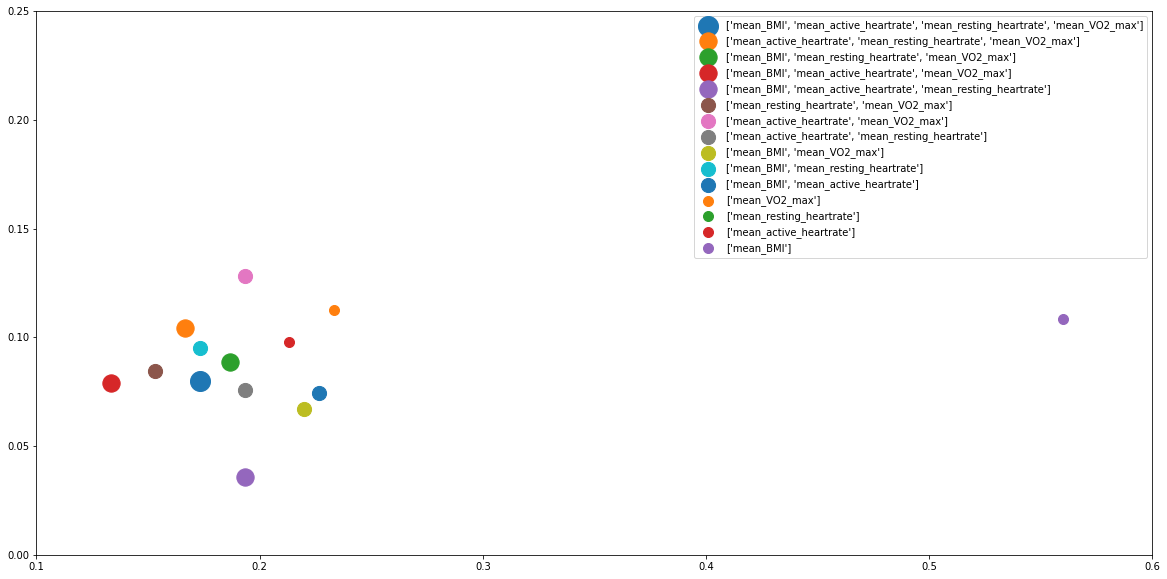

In [0]:
plt.figure(figsize=(20,10))

for _, (bias, variance, description, n_terms) in results.iterrows():
    plt.scatter(bias, variance, s=100*n_terms, label=description)
plt.xlim(0.1, 0.6)
plt.ylim(0, 0.25)
plt.legend()

In [0]:
%run ./includes/preprocessing/

In [0]:
lifestyles = health_tracker_sample_agg_pd_df.lifestyle.unique()
sample_sets = generate_subsample_sets(
  health_tracker_sample_agg_pd_df,
  lifestyles
)

feature_subsets = generate_feature_subsets(health_tracker_sample_agg_pd_df)

In [0]:
for feature_subset in feature_subsets:
    experiment_runner(
    feature_subset=feature_subset,
    model=DecisionTreeClassifier()
    )

In [0]:
results = retrieve_results(metrics=["mean score", "std score"],
                           params=["subset"])
results

,metrics.mean score,metrics.std score,params.subset
0,0.846667,0.084591,"['mean_BMI', 'mean_active_heartrate', 'mean_re..."
1,0.880000,0.071802,"['mean_active_heartrate', 'mean_resting_heartr..."
2,0.840000,0.074237,"['mean_BMI', 'mean_resting_heartrate', 'mean_V..."
3,0.813333,0.093333,"['mean_BMI', 'mean_active_heartrate', 'mean_VO..."
4,0.853333,0.106667,"['mean_BMI', 'mean_active_heartrate', 'mean_re..."
5,0.866667,0.084327,"['mean_resting_heartrate', 'mean_VO2_max']"
6,0.840000,0.120000,"['mean_active_heartrate', 'mean_VO2_max']"
7,0.826667,0.080000,"['mean_active_heartrate', 'mean_resting_heartr..."
8,0.793333,0.117189,"['mean_BMI', 'mean_VO2_max']"
9,0.880000,0.077746,"['mean_BMI', 'mean_resting_heartrate']"


In [0]:
for feature_subset in feature_subsets:
    experiment_runner(
    feature_subset=feature_subset,
    model=LogisticRegression(penalty="none", max_iter=1e4)
    )

In [0]:
results = retrieve_results(metrics=["mean score", "std score"],
                           params=["model", "subset"])
results["bias"] = 1 - results["metrics.mean score"]
results["variance"] = results["metrics.std score"]**2
results.drop(["metrics.mean score", "metrics.std score"], axis=1, inplace=True)
results.sort_values("bias").head(10)

,params.model,params.subset,bias,variance
12,LogisticRegression,['mean_resting_heartrate'],0.100000,0.003778
24,DecisionTreeClassifier,"['mean_BMI', 'mean_resting_heartrate']",0.120000,0.006044
27,DecisionTreeClassifier,['mean_resting_heartrate'],0.120000,0.007822
16,DecisionTreeClassifier,"['mean_active_heartrate', 'mean_resting_heartr...",0.120000,0.005156
20,DecisionTreeClassifier,"['mean_resting_heartrate', 'mean_VO2_max']",0.133333,0.007111
5,LogisticRegression,"['mean_resting_heartrate', 'mean_VO2_max']",0.133333,0.007111
19,DecisionTreeClassifier,"['mean_BMI', 'mean_active_heartrate', 'mean_re...",0.146667,0.011378
8,LogisticRegression,"['mean_BMI', 'mean_VO2_max']",0.146667,0.006044
15,DecisionTreeClassifier,"['mean_BMI', 'mean_active_heartrate', 'mean_re...",0.153333,0.007156
0,LogisticRegression,"['mean_BMI', 'mean_active_heartrate', 'mean_re...",0.153333,0.010711


In [0]:
results["n_terms"] = results["params.subset"].apply(lambda x: x.count(",") + 1)
results["tradeoff"] = results["bias"]**2 + results["variance"]
results.sort_values("tradeoff").head(10)


,params.model,params.subset,bias,variance,n_terms,tradeoff
12,LogisticRegression,['mean_resting_heartrate'],0.100000,0.003778,1,0.013778
16,DecisionTreeClassifier,"['mean_active_heartrate', 'mean_resting_heartr...",0.120000,0.005156,3,0.019556
24,DecisionTreeClassifier,"['mean_BMI', 'mean_resting_heartrate']",0.120000,0.006044,2,0.020444
27,DecisionTreeClassifier,['mean_resting_heartrate'],0.120000,0.007822,1,0.022222
20,DecisionTreeClassifier,"['mean_resting_heartrate', 'mean_VO2_max']",0.133333,0.007111,2,0.024889
5,LogisticRegression,"['mean_resting_heartrate', 'mean_VO2_max']",0.133333,0.007111,2,0.024889
8,LogisticRegression,"['mean_BMI', 'mean_VO2_max']",0.146667,0.006044,2,0.027556
9,LogisticRegression,"['mean_BMI', 'mean_resting_heartrate']",0.160000,0.004622,2,0.030222
15,DecisionTreeClassifier,"['mean_BMI', 'mean_active_heartrate', 'mean_re...",0.153333,0.007156,4,0.030667
17,DecisionTreeClassifier,"['mean_BMI', 'mean_resting_heartrate', 'mean_V...",0.160000,0.005511,3,0.031111


Out[80]: <matplotlib.legend.Legend at 0x7f187ef562b0>

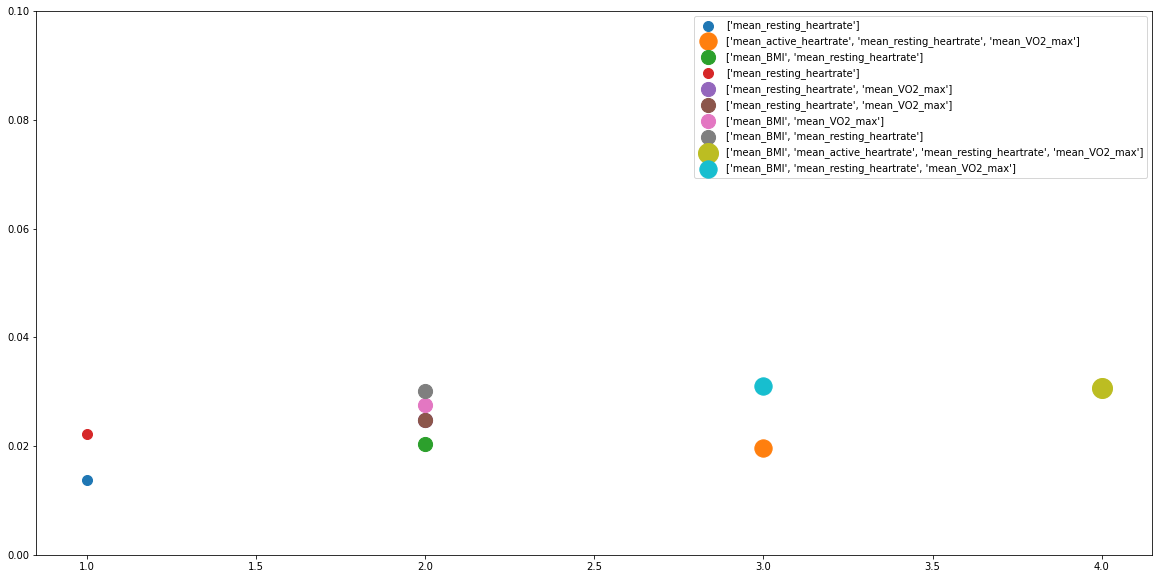

In [0]:
plt.figure(figsize=(20,10))

for _, (_, description, _, _, n_terms, tradeoff) in results.sort_values("tradeoff").head(10).iterrows():
    plt.scatter(n_terms, tradeoff, s=100*n_terms, label=description)
plt.ylim(0, 0.1)
plt.legend()
